In [1]:
%load_ext autoreload 

In [2]:
autoreload 2

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import sympy as sym
import seaborn as sn

import pycollocation

<h1> The Solow model </h1>

$$ \dot{k}(t) = s f(k(t)) - (g + n + \delta) k(t),\ k(0) = k_0 $$

In [5]:
# define some variables
t, k, c = sym.symbols('t, k, c')

# define some parameters
alpha, sigma = sym.symbols('alpha, sigma')
rho, theta = sym.symbols('rho, theta')
g, n, s, delta = sym.symbols('g, n, s, delta')

In [6]:
def intensive_output(k, alpha, sigma, **params):
    rho = (sigma - 1) / sigma
    if rho == 0:
        y = k**alpha
    else:
        y = (alpha * k**rho + (1 - alpha))**(1 / rho)
    return y

def rhs(t, k, delta, g, n, s, **params):
    return [s * intensive_output(k, **params) - (g + n + delta) * k]

def bcs_lower(t, k, k0, **params):
    return [k - k0]

solow_params = {'g': 0.02, 's': 0.1, 'n': 0.02, 'alpha': 0.15, 'sigma': 2.0,
                'delta': 0.04, 'k0': 1.0}

In [7]:
solow_model = pycollocation.IVP(bcs_lower=bcs_lower,
                                number_bcs_lower=1,
                                number_odes=1,
                                rhs=rhs)

In [8]:
solver = pycollocation.PolynomialSolver()

In [9]:
def steady_state_capital(g, n, s, alpha, delta, sigma, **params):
    """Steady state value for capital stock (per unit effective labor)."""
    rho = (sigma - 1) / sigma
    if rho == 0:
        kss = (s / (g + n + delta))**(1 / (1 - alpha))
    else:
        kss = ((1 - alpha) / (((g + n + delta) / s)**rho - alpha))**(1 / rho)
    return kss

domain = [0, 100]
kstar = steady_state_capital(**solow_params)
ts = np.linspace(domain[0], domain[1], 1000)
ks = kstar - (kstar - solow_params['k0']) * np.exp(-ts)

initial_poly = np.polynomial.Chebyshev.fit(ts, ks, 15, domain)
initial_coefs = initial_poly.coef


In [10]:
nodes = solver.collocation_nodes(15, domain, "Chebyshev")

In [11]:
k_hat, = solver.solve(initial_coefs, domain, nodes, solow_params, solow_model, kind="Chebyshev")

In [12]:
import matplotlib.pyplot as plt

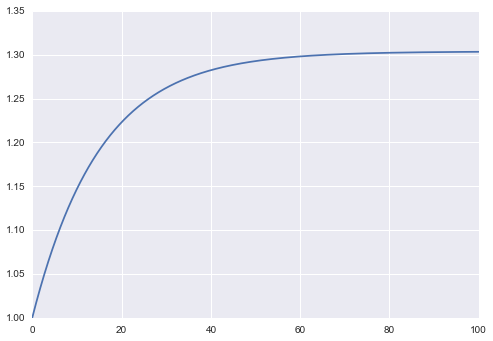

In [13]:
ts = np.linspace(0, 100, 1000)
plt.plot(ts, k_hat(ts))

In [5]:
solow = pycollocation.SymbolicBoundaryValueProblem(dependent_vars=['k'],
                                                   independent_var='t',
                                                   rhs=rhs,
                                                   boundary_conditions=bcs,
                                                   params=solow_params)

In [6]:
solow_solver = pycollocation.OrthogonalPolynomialSolver(solow)

In [8]:
solow_solver.solve(kind="Chebyshev",
                   coefs_dict=initial_coefs,
                   domain=domain)

In [9]:
solow_viz = pycollocation.Visualizer(solow_solver)

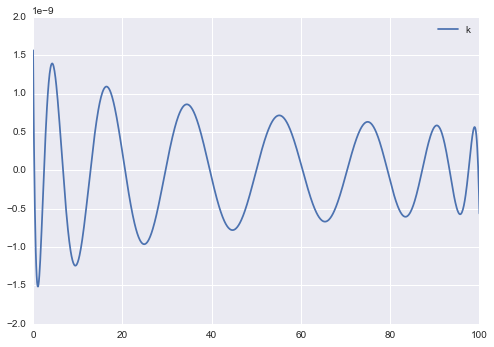

In [10]:
solow_viz.interpolation_knots = np.linspace(0, 100, 1000)
solow_viz.residuals.plot()

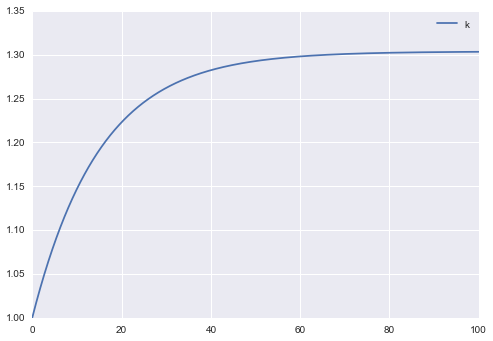

In [11]:
solow_viz.solution.plot()